# Part 2 - Transfer learning Bees vs Ants

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_2_bee_vs_ant.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/thomasjpfan/skorch_talk/blob/master/part_2_bee_vs_ant.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_2_bee_vs_ant.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

This tutorial converts the pure PyTorch approach described in [PyTorch's Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) to `skorch`

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch

     |████████████████████████████████| 102kB 2.7MB/s 


## Download data

In [0]:
%matplotlib inline

import os
from urllib import request
from zipfile import ZipFile
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
def download_and_extract_data(dataset_dir=Path('data')):
    dataset_dir.mkdir(exist_ok=True)
    data_zip = os.path.join(dataset_dir, 'hymenoptera_data.zip')
    data_path = os.path.join(dataset_dir, 'hymenoptera_data')
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

    if not os.path.exists(data_path):
        if not os.path.exists(data_zip):
            print("Starting to download data...")
            data = request.urlopen(url, timeout=15).read()
            with open(data_zip, 'wb') as f:
                f.write(data)

        print("Starting to extract data...")
        with ZipFile(data_zip, 'r') as zip_f:
            zip_f.extractall(dataset_dir)
        
    print("Data has been downloaded and extracted to {}.".format(dataset_dir))
    
download_and_extract_data()

Starting to download data...
Starting to extract data...
Data has been downloaded and extracted to data.


## Explore Data

In [0]:
from glob import glob
from PIL import Image

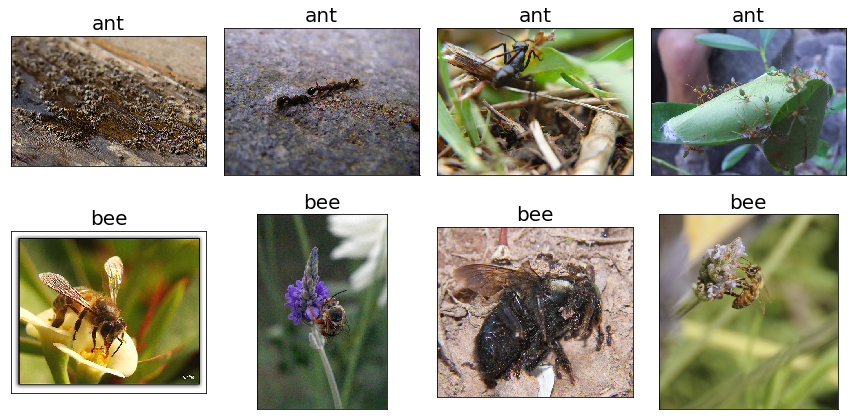

In [8]:
data_dir = 'data/hymenoptera_data'

Path('images').mkdir(exist_ok=True)

ant_image_fns = glob(os.path.join(data_dir, "train/ants/*"))[4:8]
bee_image_fns = glob(os.path.join(data_dir, "train/bees/*"))[4:8]
all_image_fns = [('ant', fn) for fn in  ant_image_fns] + [('bee', fn) for fn in bee_image_fns]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for (label, fn), ax in zip(all_image_fns, axes.flatten()):
    img = Image.open(fn)
    ax.set_title(label, fontsize=20)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig("images/bee_vs_ant_images.jpg")

## Using torchvision

In [0]:
import torchvision.transforms as tfms
from torchvision.datasets import ImageFolder

train_tfms = tfms.Compose([
    tfms.RandomResizedCrop(224),
    tfms.RandomHorizontalFlip(),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], 
                   [0.229, 0.224, 0.225])
])

train_ds = ImageFolder(
    os.path.join(data_dir, "train") , train_tfms
)

In [0]:
val_tfms = tfms.Compose([
    tfms.RandomResizedCrop(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], 
                   [0.229, 0.224, 0.225])
])

val_ds = ImageFolder(
    os.path.join(data_dir, "val"), val_tfms,)

In [14]:
len(train_ds), len(val_ds)

(244, 153)

In [0]:
img, target = train_ds[0]

In [16]:
img.shape, target

(torch.Size([3, 224, 224]), 0)

In [17]:
train_ds.class_to_idx

{'ants': 0, 'bees': 1}

## Pretrained model

In [0]:
from torchvision.models import resnet18
import torch.nn as nn

class PretrainedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 2)
        
    def forward(self, X):
        return self.model(X)

## Skorch callbacks

## Freezer

In [0]:
from skorch.callbacks import Freezer

freezer = Freezer(lambda x: not x.startswith('model.fc'))

### LRScheduler

In [0]:
from skorch.callbacks import LRScheduler

lr_scheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1
)

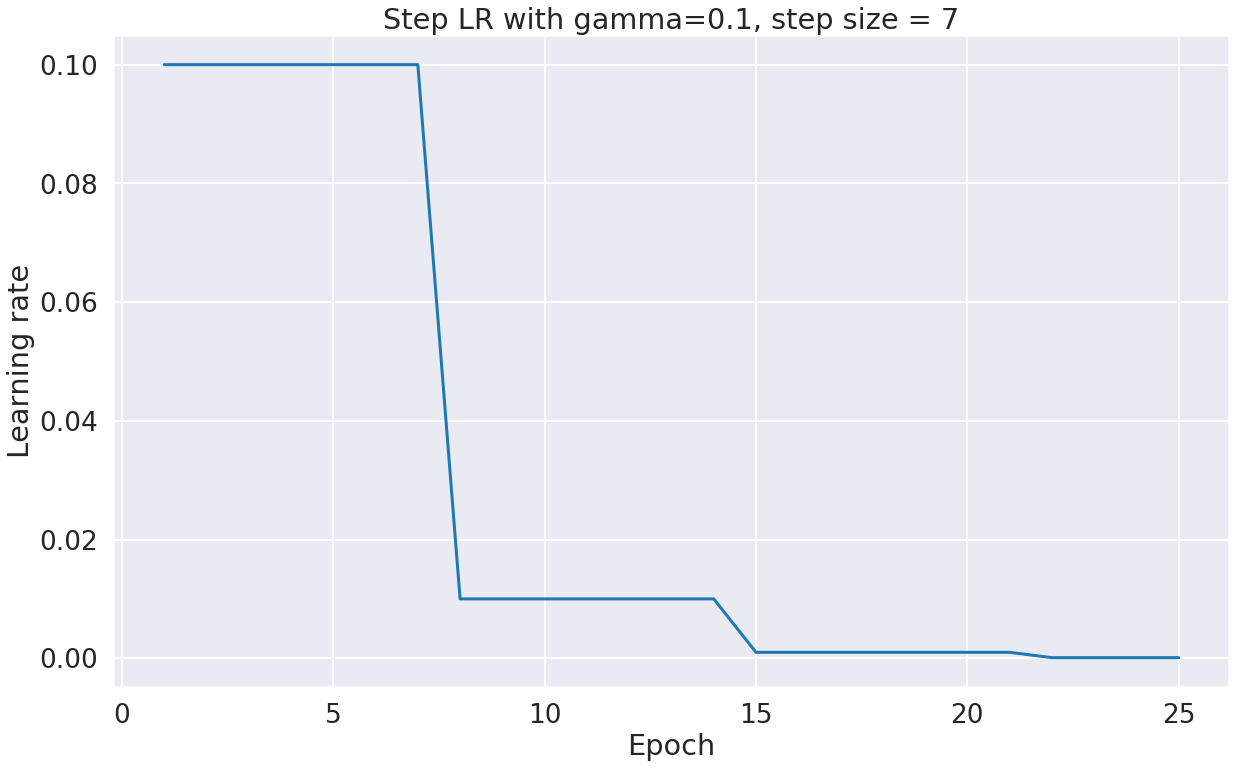

In [45]:
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster', font_scale=1.2)

max_epochs = 25
epochs = np.arange(1, max_epochs+1)
lrs = lr_scheduler.simulate(max_epochs, initial_lr=0.1)

fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_alpha(0)
ax.set_title("Step LR with gamma=0.1, step size = 7")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Epoch")
_ = ax.plot(epochs, lrs)
fig.savefig("images/step_lr.png")

### EpochScoring

In [0]:
from sklearn.metrics import accuracy_score, make_scorer
from skorch.callbacks import EpochScoring

def accuracy_argmax(y_true, y_pred):
    return accuracy_score(y_true, np.argmax(y_pred, -1))
accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

## Checkpoint

In [0]:
from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    dirname="exp_01_bee_vs_ant", monitor="valid_acc_best")

## skorch NeutralNet

In [0]:
from skorch import NeuralNet
import torch.nn as nn
import torch.optim as optim
from skorch.helper import predefined_split

net = NeuralNet(
    PretrainedModel,
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=4,
    max_epochs=10,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer, lr_scheduler, epoch_acc, checkpoint],
    device='cuda' # comment to train on cpu
)

In [49]:
_ = net.fit(train_ds)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.7208       0.8497        0.3601     +  2.5250
      2        0.5829       0.8889        0.2379     +  3.0037
      3        0.5263       0.8693        0.3079        3.0293
      4        0.5459       0.9608        0.1721     +  3.0325
      5        0.3163       0.9216        0.1816        3.0301
      6        0.4067       0.9020        0.2264        2.9828
      7        0.4507       0.9216        0.2066        3.0625
      8        0.4339       0.9020        0.2560        3.0106
      9        0.3486       0.9216        0.2232        2.9827
     10        0.3156       0.9412        0.1548        2.9725


In [0]:
net.load_params(checkpoint=checkpoint)
val_output = net.predict(val_ds)

In [51]:
print(val_output.shape)

(153, 2)


## Saving and loading (Extra)

In [0]:
from skorch.callbacks import LoadInitState

def run(max_epochs):
    checkpoint = Checkpoint(
        dirname="exp_02_bee_vs_ant", monitor="valid_acc_best")
    train_end_cp = TrainEndCheckpoint(
        dirname="exp_02_bee_vs_ant", fn_prefix="train_end_")
    load_state = LoadInitState(train_end_cp)

    net = NeuralNet(
        PretrainedModel,
        criterion=nn.CrossEntropyLoss,
        lr=0.001,
        batch_size=4,
        max_epochs=max_epochs,
        optimizer=optim.SGD,
        optimizer__momentum=0.9,
        iterator_train__shuffle=True,
        iterator_train__num_workers=4,k
        iterator_valid__shuffle=False,
        iterator_valid__num_workers=4,
        train_split=predefined_split(val_ds),
        callbacks=[freezer, lr_scheduler, epoch_acc, 
                   checkpoint, train_end_cp, load_state],
        device='cuda' # comment to train on cpu
    ).fit(train_ds)

In [0]:
# First run
run(max_epochs=10)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5797       0.8562        0.3028     +  0.9013
      2        0.6500       0.9281        0.1937     +  0.8943
      3        0.5342       0.8954        0.2112        0.9007
      4        0.5842       0.8824        0.2693        0.9002
      5        0.6256       0.6993        0.6912        0.9168
      6        0.6043       0.9412        0.1579     +  0.9294
      7        0.4654       0.9216        0.1940        0.8968
      8        0.3341       0.9216        0.2160        0.8990
      9        0.3844       0.8889        0.2530        0.9011
     10        0.3591       0.9216        0.2141        0.8928


In [0]:
# Second run
run(max_epochs=5)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
     11        0.3275       0.9216        0.2345     +  1.3394
     12        0.3370       0.9281        0.1768     +  1.3734
     13        0.3204       0.9477        0.1255     +  1.3578
     14        0.3315       0.9477        0.1819        1.3832
     15        0.3374       0.8889        0.2308        1.3958


In [0]:
# prediction
checkpoint = Checkpoint(
    dirname="exp_02_bee_vs_ant", monitor="valid_acc_best")
train_end_cp = TrainEndCheckpoint(
    dirname="exp_02_bee_vs_ant", fn_prefix="train_end_")
load_state = LoadInitState(train_end_cp)

net = NeuralNet(
    PretrainedModel,
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=4,
    max_epochs=10,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer, lr_scheduler, epoch_acc, 
               checkpoint, train_end_cp, load_state],
    device='cuda' # comment to train on cpu
)

net.initialize()
net.load_params(checkpoint=checkpoint)

## Prediction Numpy

In [0]:
X_numpy = val_ds[0][0].numpy()[None, :]

In [53]:
X_numpy.shape

(1, 3, 224, 224)

In [0]:
X_pred = net.predict(X_numpy)

In [55]:
X_pred

array([[ 1.2618265, -1.3732657]], dtype=float32)

In [56]:
from sklearn.utils.extmath import softmax

print(softmax(X_pred))

[[0.93308616 0.06691381]]
